## Importing

In [96]:
#!/usr/bin/env python

try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
import pandas
import certifi
import json
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
from dateutil import parser
import matplotlib.pyplot as plt
import csv
import os
import ast
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree, metrics
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
import warnings
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import time
from typing import List, Dict
from functools import reduce
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn import datasets, metrics, svm
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SelectFromModel
from IPython.display import Image
from scipy import interp
import matplotlib.patches as patches
import statsmodels.api as sm
warnings.filterwarnings('ignore')
import h5py
warnings.resetwarnings()


# Initial Observation

First of all, we'd like to see how different features distribute, how they correlate with each other and also find out more statistic information about them 

For now we'll focus on Apple stock

#### Raw Data

In [97]:
df= pd.read_csv('C:/Users/niroe/OneDrive/Documents/Important/project/df_daily/Observed/AAPL.csv')
df.head()

date     open     high      low   close    adjClose     volume   
0  2023-06-09  181.500  182.230  180.630  180.99  180.960007   32456348  \
1  2023-06-08  177.895  180.840  177.460  180.57  180.570007   50210681   
2  2023-06-07  178.440  181.210  177.320  177.82  177.820007   61944615   
3  2023-06-06  179.965  180.120  177.430  179.21  179.210007   64845314   
4  2023-06-05  182.630  184.951  178.035  179.58  179.580002  121722517   

   unadjustedVolume  change  changePercent    vwap        label   
0          47304520  -0.510       -0.28099  181.58  June 09, 23  \
1          50214900   2.675        1.50000  179.55  June 08, 23   
2          61944600  -0.620       -0.34746  178.66  June 07, 23   
3          64848400  -0.755       -0.41953  178.71  June 06, 23   
4         121946500  -3.050       -1.67000  182.14  June 05, 23   

   changeOverTime  
0       -0.002810  
1        0.015000  
2       -0.003475  
3       -0.004195  
4       -0.016700

The features in the data are:
- Date: A string containing the observation's date.
- Open: The opening price of the stock on the date of the observation.
- High: The highest price the stock had on the trading day of the observation.
- Low: The lowest price the stock had on the trading day of the observation.
- Close: The closing price of the stock on the date of the observation.
- AdjClose: The closing price of the stock on the date of the observation after dividends.
- Volume: Number of stocks being traded on the day of the observation.
- UnAdjustedVolume: Same as Volume, but without any adjustments.
- Change: The difference between the open and close.
- ChangePercent: Same as change but in percentages.
- VWAP: VWAP stands for Volume-Weighted Average Price of the stock in the observation. 
- Label: The date of the observation as a different string then the "Date" feature.
- ChangeOverTime: "ChangePercent" divided by 100.

### Visualization

##### Viewing the whole data at once

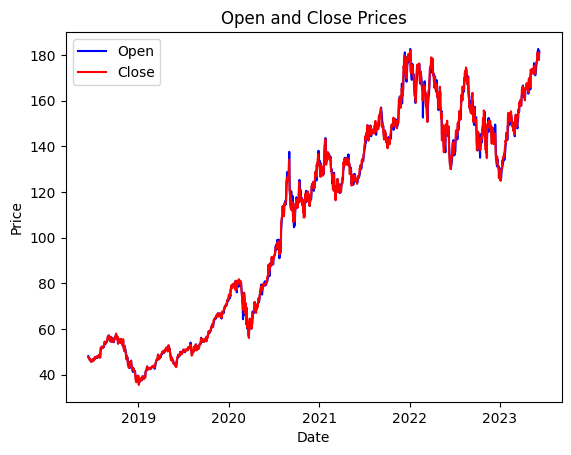

In [98]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Set up the figure and axis
fig, ax = plt.subplots()

# Plot 'open' and 'close' prices
ax.plot(df['date'], df['open'], color='blue', label='Open')
ax.plot(df['date'], df['close'], color='red', label='Close')

# Set the title and axis labels
ax.set_title('Open and Close Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Add a legend
ax.legend()

# Display the plot
plt.show()

##### Viewing each month separately for better viewing

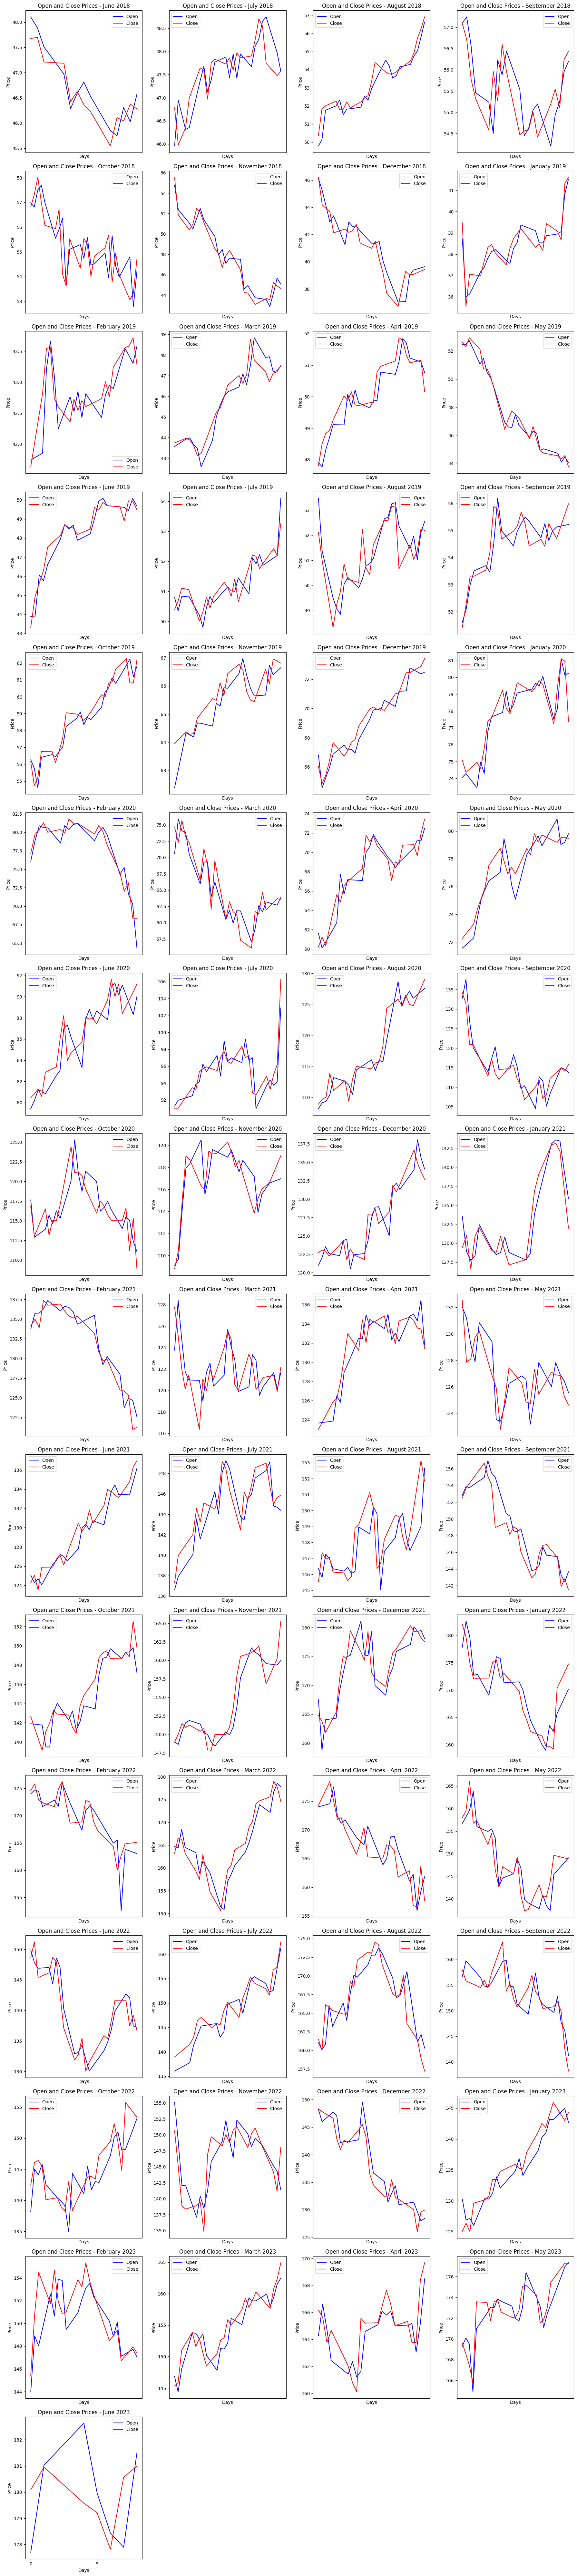

In [99]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Group data by month
grouped_data = df.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['open'], color='blue', label='Open')
    ax.plot(days, group['close'], color='red', label='Close')
    ax.set_title(f"Open and Close Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

##### Using a correlation matrix to figure out which features are best for analyzing the data

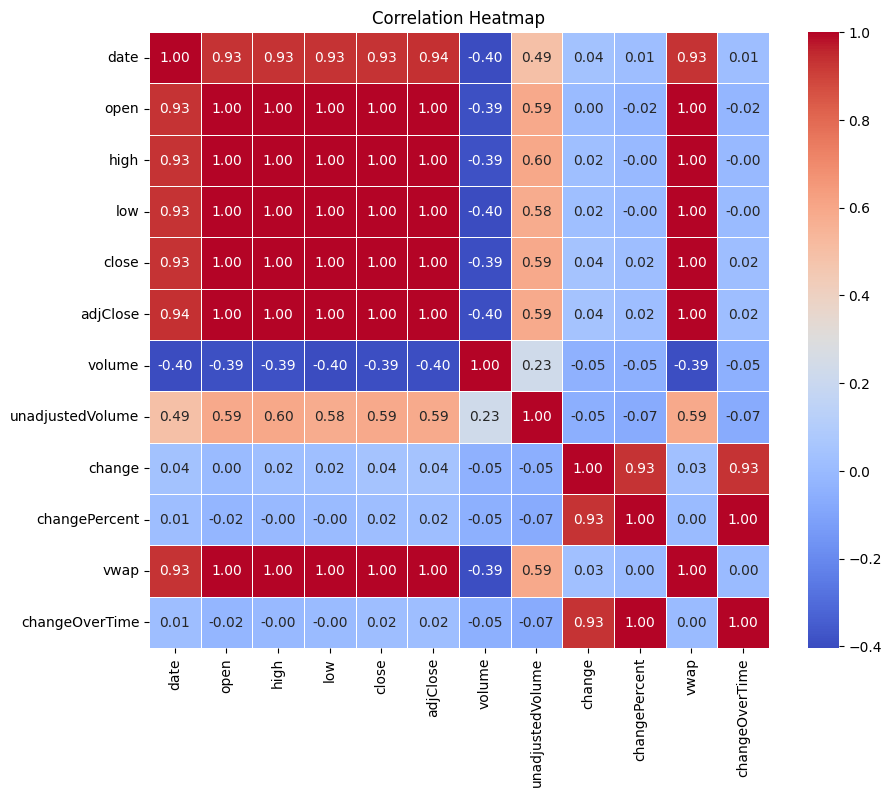

Correlation with Target Variable:
open                1.000000
high                0.999679
vwap                0.999622
low                 0.999613
close               0.999172
adjClose            0.999119
date                0.931200
unadjustedVolume    0.591784
volume              0.392411
changeOverTime      0.022124
changePercent       0.022124
change              0.000295
Name: open, dtype: float64
Best Features to Analyze the Data:
['high', 'vwap', 'low']


In [100]:
# Convert 'Date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

df.drop("label", axis=1, inplace=True)

# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax)

# Set the title
ax.set_title('Correlation Heatmap')

# Display the heatmap
plt.show()

# Select the target variable
target_variable = 'open'

# Calculate the correlation between each feature and the target variable
correlation_with_target = correlation_matrix[target_variable].abs().sort_values(ascending=False)

# Print the correlation with the target variable
print("Correlation with Target Variable:")
print(correlation_with_target)

# Select the top-k features with the highest absolute correlation coefficients
k = 3
best_features = correlation_with_target[1:k+1].index.tolist()

# Print the best features
print("Best Features to Analyze the Data:")
print(best_features)

Conclusions
 - For featurs with strong correlation with the prediction ('open') feature we will assume that they will be the most important features to affect and contribute our modeling of the data set in the next part. Particularly, the features '' and '', that we can see from the heatmap. 
 - We can also see a very strong correlation between features such as 'ChangePercent' and 'ChangeOverTime'. That is because they're basically a manipulation of the same feature ('Change'). In our PreProcessing part, we'll reduce the number of features to lower the complexity of our ML module.

# Preprocessing  

Now, we'll deep dive into the data and try to figure out how to deal with outliers, if the data is standardized, how to deal with missing data, how to compute categorial features into our models, addition of new features if needed and trying to reduce the dimensionality of the data to make our models less complex while explaining as much of the dataset's variation as possible.

We want to see the affect on the opening price by percentiles, so we'll work on the log of the price as our predicted value.

In this part we'll also divide our dataset into train data and test data randomly. We're taking this course of action so we can see how well our unsupervised modules preform at making opening prices predictions. 

In [101]:
#df['log_price'] = np.log(df['open'])
#df.drop('open', axis=1, inplace=True)

Spliting the data into train data and test data for our prediction

In [102]:
#test_data, train_data = train_test_split(df.copy(), test_size = 0.8, random_state= 42, shuffle=True)
train_data = df.iloc[:int(len(df) * 0.9)]
test_data = df.iloc[int(len(df) * 0.9):]

Removing the prediction feature - log_opening_price, from the test dataset, and save it as a new variable.
We do this in order to compare our results of the prediction log_opening_price to the actual log_opening_price of the test dataset at the end of the Modeling section. 

In [103]:
#actual_test_log_price = pd.DataFrame(test_data["log_price"])
#test_data.drop("log_price", axis=1, inplace=True)
#train_data.shape

The dataset that we chose randomly has  observations and  features. Therefore, because it's relatively big, this train dataset is indeed representative and canhelp us make strong predictions with regards to the opening price of the stock in the future (if it will rise, fall or keep a relatively stable price inside a "safety zone" that will be determind later on).

C:\Users\niroe\AppData\Local\Temp\ipykernel_21824\3955620938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['date'] = pd.to_datetime(train_data['date'])


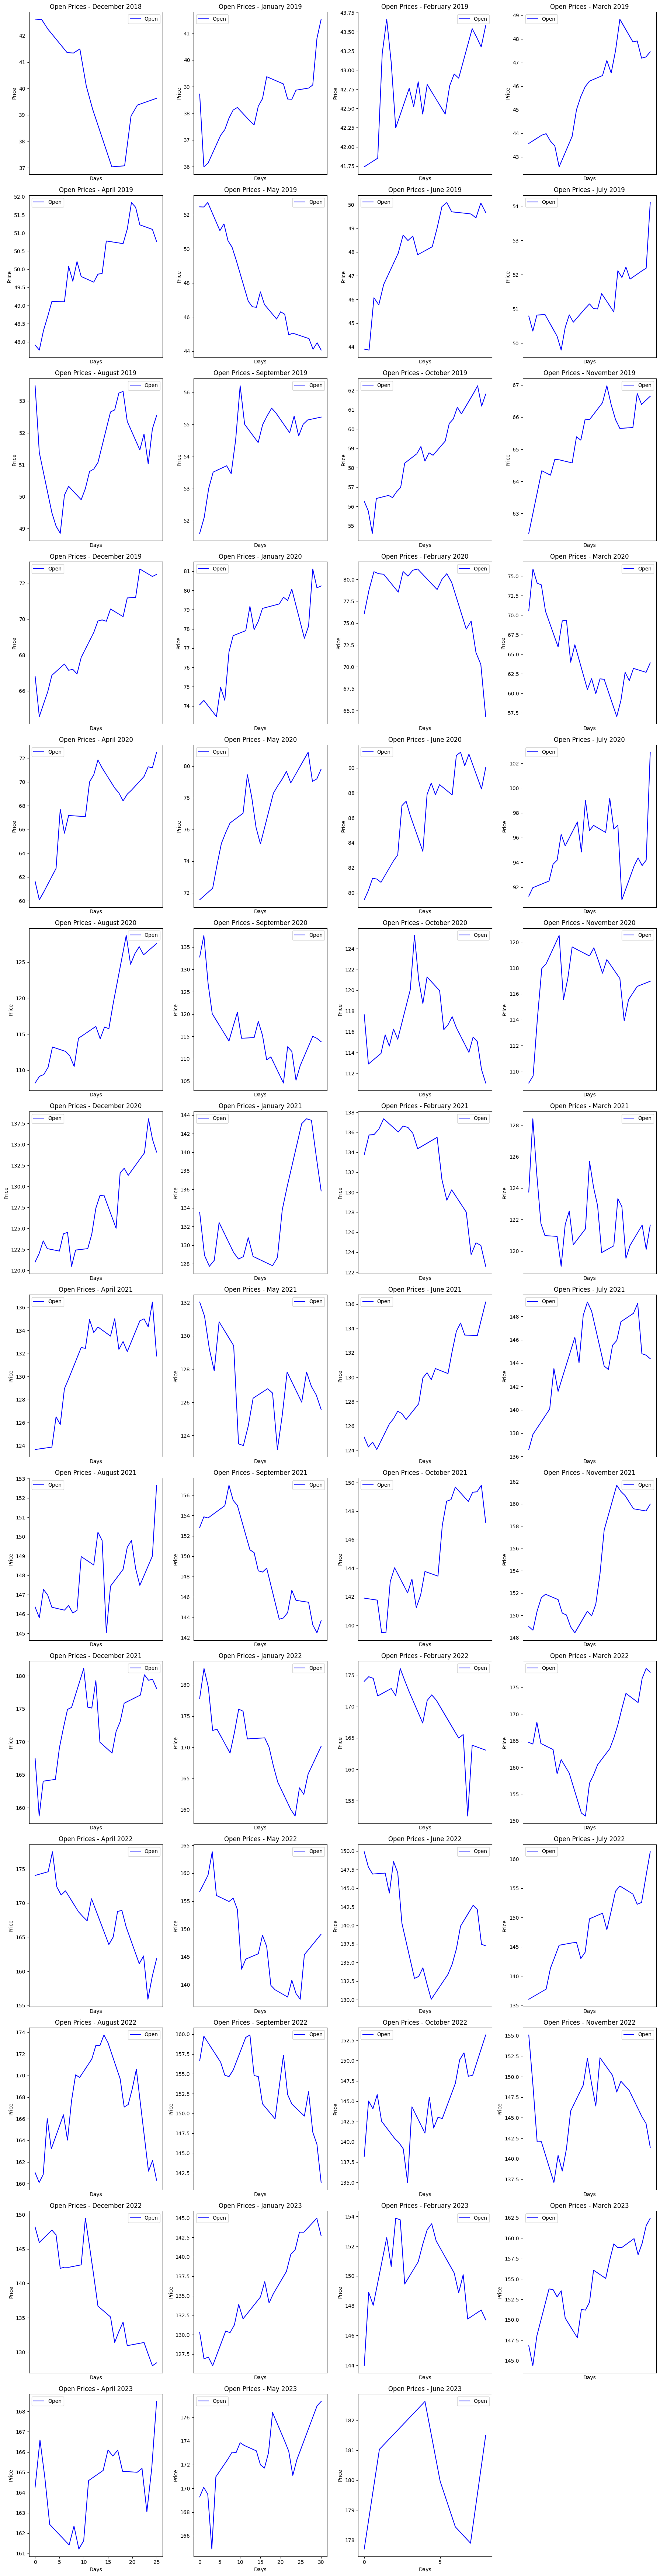

In [104]:
# Convert 'date' column to datetime type
train_data['date'] = pd.to_datetime(train_data['date'])

# Group data by month
grouped_data = train_data.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['open'], color='blue', label='Open')

    ax.set_title(f"Open Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### Dealing with outliers

In the previous part we noticed some outliers in some of the features by reviewing the histograms and boxplots. Now we will handle them by removing extreme values that can have an unproportionate effect on our modules

Our way of doing that will be by changing the top and bottom percentiles, which we think will eliminate most of the unwanted values while not changing too many observations

Step 1: Identifying Outliers using np.diff

In [105]:
# Calculate the differences between consecutive open prices, excluding the first date
train_data['price_diff'] = np.diff(train_data['open'], prepend=train_data['open'].iloc[0])

# Calculate the lower and upper percentiles for outliers
lower_percentile = np.percentile(train_data['price_diff'], 1)
upper_percentile = np.percentile(train_data['price_diff'], 99)

# Identify outliers based on the percentiles
outliers = train_data.iloc[:-1][(train_data['price_diff'] < lower_percentile) | (train_data['price_diff'] > upper_percentile)]

C:\Users\niroe\AppData\Local\Temp\ipykernel_21824\2057737182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['price_diff'] = np.diff(train_data['open'], prepend=train_data['open'].iloc[0])
C:\Users\niroe\AppData\Local\Temp\ipykernel_21824\2057737182.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = train_data.iloc[:-1][(train_data['price_diff'] < lower_percentile) | (train_data['price_diff'] > upper_percentile)]


Step 2: Dealing with Outliers using Moving Average

In [106]:
# Calculate the weighted moving average of log_price with a 4-observation window
weights = [0.05, 0.15, 0.25, 0.55]  # Example weights for the 4-observation window

window_size = 4
train_data['weighted_avg'] = np.nan

for i in range(window_size, len(train_data)):
    window_values = train_data.iloc[i - window_size:i, train_data.columns.get_loc('open')]
    
    if len(window_values) > 0:
        weighted_avg = np.sum(window_values * weights) / np.sum(weights)
        train_data.loc[i, 'weighted_avg'] = weighted_avg

# Update the log_price of outliers with the weighted moving average values
train_data.loc[outliers.index, 'open'] = train_data.loc[outliers.index, 'weighted_avg']

# Interpolate missing values in log_price
train_data['open'].interpolate(method='linear', inplace=True)

# Drop the 'weighted_avg' column
train_data.drop('weighted_avg', axis=1, inplace=True)
train_data.drop('price_diff', axis=1, inplace=True)

C:\Users\niroe\AppData\Local\Temp\ipykernel_21824\2665762292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['weighted_avg'] = np.nan


C:\Users\niroe\AppData\Local\Temp\ipykernel_21824\2665762292.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['open'].interpolate(method='linear', inplace=True)
C:\Users\niroe\AppData\Local\Temp\ipykernel_21824\2665762292.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop('weighted_avg', axis=1, inplace=True)
C:\Users\niroe\AppData\Local\Temp\ipykernel_21824\2665762292.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Viewing the changes:

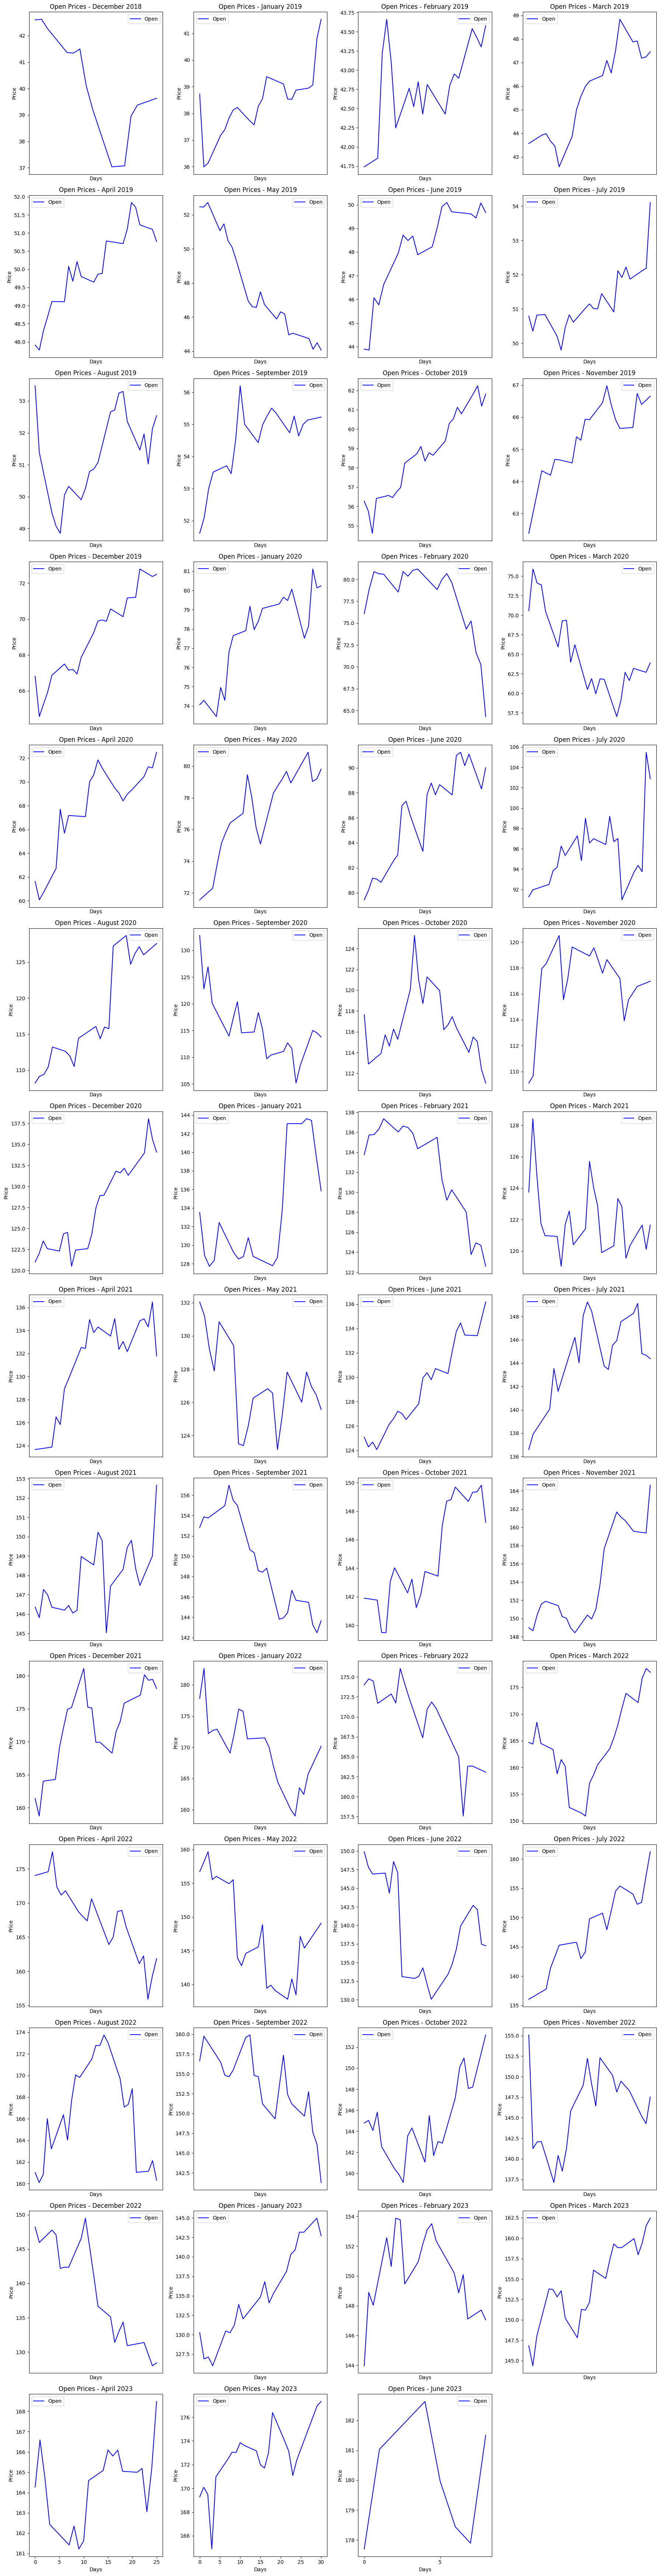

In [107]:
# Group data by month
grouped_data = train_data.groupby(pd.Grouper(key='date', freq='M'))

# Calculate the number of rows and columns for subplots
num_months = len(grouped_data)
num_cols = 4  # Four subplots in each row

# Calculate the number of rows needed based on the number of subplots
num_rows = (num_months + num_cols - 1) // num_cols

# Set up the figure and subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

# Iterate over the grouped data and plot 'open' and 'close' prices for each month
for i, (month, group) in enumerate(grouped_data):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    days = (group['date'] - group['date'].min()).dt.days
    ax.plot(days, group['open'], color='blue', label='Open')

    ax.set_title(f"Open Prices - {month.strftime('%B %Y')}")
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.legend()

    # Hide x-axis ticks for all but the bottom row
    if row != num_rows - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(days.min(), days.max() + 1, 5))

# Hide any unused subplots
for i in range(num_months, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

As we can see by the plots, due to us 'flattening' the outliers, the open prices have a smaller range of values<br>As a result, the plots now have a 'smoother' line

### Dealing with overlaping features

As we can see from our data exploration, the data contains some overlaping features. In this section we'll drop unnecessary features. This will help lower the complexity of the ML modules we'll use later on while maintaining maximum explanatory power of the variable we want to predict in our models. 

The next function takes a categorial feature and turnes it into a set of dummy variables:

In [108]:
def Get_Dummies(feature, predict_feature, train_data, test_data):
    train_data = pd.get_dummies(train_data, prefix=[feature], columns = [feature], drop_first=True)
    ordered_cols = [x for x in train_data.columns if x not in[predict_feature]] + [predict_feature]
    train_data = train_data[ordered_cols]
    test_data = pd.get_dummies(test_data, prefix=[feature], columns = [feature], drop_first=True)
    return train_data, test_data

* Turning 'day', 'month' and 'year' into dummy variables

In [109]:
#train_data, test_data = Get_Dummies('day', 'log_price', train_data, test_data)
#train_data, test_data = Get_Dummies('month', 'log_price', train_data, test_data)
#train_data, test_data = Get_Dummies('year', 'log_price', train_data, test_data)

In [110]:
train_data.shape, test_data.shape

((1131, 12), (126, 12))

In [111]:
train_data

date      open      high       low     close    adjClose   
0    2023-06-09  181.5000  182.2300  180.6300  180.9900  180.960007  \
1    2023-06-08  177.8950  180.8400  177.4600  180.5700  180.570007   
2    2023-06-07  178.4400  181.2100  177.3200  177.8200  177.820007   
3    2023-06-06  179.9650  180.1200  177.4300  179.2100  179.210007   
4    2023-06-05  182.6300  184.9510  178.0350  179.5800  179.580002   
...         ...       ...       ...       ...       ...         ...   
1126 2018-12-18   41.3450   41.8825   41.0975   41.5175   39.955334   
1127 2018-12-17   41.3625   42.0875   40.6825   40.9850   39.442863   
1128 2018-12-14   42.2500   42.2700   41.3200   41.3700   39.813381   
1129 2018-12-13   42.6225   43.1425   42.3875   42.7375   41.129417   
1130 2018-12-12   42.6000   42.9800   42.2550   42.2750   40.684330   

         volume  unadjustedVolume  change  changePercent    vwap   
0      32456348          47304520 -0.5100       -0.28099  181.58  \
1      50210681          50214900  2.6750        1.50000  179.55   
2      61944615          61944600 -0.6200       -0.34746  178.66   
3      64845314          64848400 -0.7550       -0.41953  178.71   
4     121722517         121946500 -3.0500       -1.67000  182.14   
...         ...               ...     ...            ...     ...   
1126  135366072          33841518  0.1725        0.41722   41.48   
1127  176888088          44222022 -0.3775       -0.91266   41.36   
1128  162677640          40669410 -0.8800       -2.08000   41.66   
1129  127591308          31897827  0.1150        0.26981   42.74   
1130  142510636          35627659 -0.3250       -0.76291   42.57   

      changeOverTime  
0          -0.002810  
1           0.015000  
2          -0.003475  
3          -0.004195  
4          -0.016700  
...              ...  
1126        0.004172  
1127       -0.009127  
1128       -0.020800  
1129        0.002698  
1130       -0.007629  

[1131 rows x 12 columns]

Before dealing with dimentionality reduction and normalization, we will devide the dataset into x train, y train and x test:

* חלוקה לסך המשתנים ולמשתנה לחיזוי עבור סט האימון וסט המבחן

In [112]:
#left_columns = train_data.iloc[:, :1]
#right_columns = train_data.iloc[:, 2:]
#X_train = pd.concat([left_columns, right_columns], axis=1)
#y_train = train_data.iloc[:,1]
X_test = test_data.iloc[:,:].values

In [113]:
# X_train
X_train = train_data

In [114]:
features_train = X_train
#features_train.drop('log_price', axis=1, inplace=True)

After these changes, let's see how our train dataset looks like:

In [115]:
train_data_features, test_data_features = np.array(features_train.columns), np.array(test_data.columns)
print(f"Train data features: {train_data_features}\n\n Test data features: {test_data_features}")

Train data features: ['date' 'open' 'high' 'low' 'close' 'adjClose' 'volume' 'unadjustedVolume'
 'change' 'changePercent' 'vwap' 'changeOverTime']

 Test data features: ['date' 'open' 'high' 'low' 'close' 'adjClose' 'volume' 'unadjustedVolume'
 'change' 'changePercent' 'vwap' 'changeOverTime']


Dropping the date column for the dimension reduction and saving it for later use

In [116]:
save_the_date_train = X_train.iloc[:, 0]
X_train = X_train.iloc[:, 1:]
save_the_date_test = X_test[:, 0]
X_test = X_test[:, 1:]
train_data_features = train_data_features[1:]
test_data_features = test_data_features[1:]

### Dealing with Standardization

In our data, some of the features are normalized and some aren't. Data normalization is the method of organizing data to appear similar across all records and fields. Performing so always results in getting higher quality data and better results. This process basically includes eliminating unstructured data and duplicates in order to ensure logical data storage.

Normalizing all features to be between 0 and 1 by reducing the minimal value and dividing by the max (according to the distributions found in the train dataset):

In [117]:
scaler = StandardScaler()
X_train_normalize = scaler.fit_transform(X_train)
X_test_normalize = scaler.fit_transform(X_test)

### Dimentionality reduction process


### Forward Selection

Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.

our "punishment" method in which we'll evaluate the number of features will be Mallow's C_p.
In statistics, Mallows's Cp is used to assess the fit of a regression model that has been estimated using ordinary least squares. It is applied in the context of model selection, where a number of predictor variables are available for predicting some outcome, and the goal is to find the best model involving a subset of these predictors. A small value of Cp means that the model is relatively precise.

$ C_p= MSE+2\frac{d+1}{n}\hat{\sigma}^2$ <br><br>
Where : $ \hat{\sigma}^2 = \frac{RSS_{all features}}{n-\#features-1} $,   and $\#features$ is the number of all features

We'll evaluate our Forward Feature Selection using Mallow's C_p

![https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg](https://slideplayer.com/slide/4646748/15/images/7/Forward+Selection+%28wrapper%29.jpg)

Feature Selection with Linear Regression:

In [118]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    reg  = LinearRegression()
    reg.fit(X, y)
    y_preds = reg.predict(X)
    MSE = mean_squared_error(y, y_preds)
    RSS = MSE * len(X)
    sigma_hat_squared = RSS / (len(X) - len(X[1]) - 1)
    return sigma_hat_squared

In [119]:
def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    reg  = LinearRegression() 
    reg.fit(X, y)
    preds = reg.predict(X)
    MSE = mean_squared_error(y, preds)
    d = X.shape[1]
    n = len(X)
    Cp = MSE + (2* sigma_hat_squared * (d + 1)) / n
    return Cp

In [120]:
def add_feature(X: np.array ,y: np.array ,current_features, sigma_hat_squared: float):
    best_score = np.inf
    num_of_features = X.shape[1]
    for i in range(num_of_features):
        if i in current_features:
            continue
        current_features_copy_added_feature = current_features.copy()
        current_features_copy_added_feature.append(i)
        current_features_copy_added_feature.sort()
        current_Cp = get_mallows_cp_score(X[:, current_features_copy_added_feature], y, sigma_hat_squared) 
        if (current_Cp <= best_score):
            best_score = current_Cp
            best_features_lst = current_features_copy_added_feature
      
    return {'features':sorted(best_features_lst),'score':best_score}  

In [121]:
def forward_selection(X: np.array, y: np.array):
    num_of_features = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)

    models_lst = []
    for i in range(num_of_features):
        res = add_feature(X,y,current_features,sigma_hat_squared)
        models_lst.append(res)
        current_features = models_lst[-1]['features']
    
    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst, 'g')
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

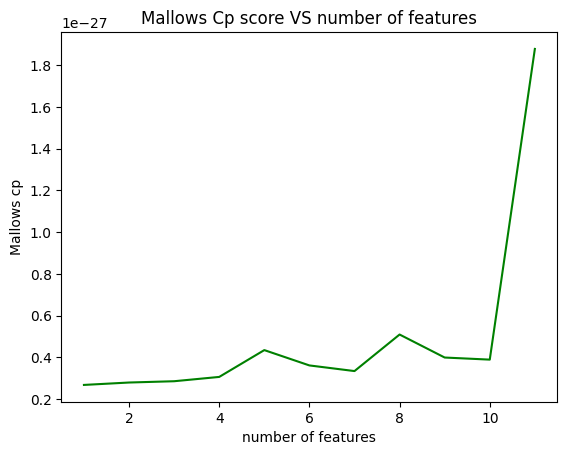

number of selected features by forward: 1
best features by forward: [0]


In [122]:
best_features_list = forward_selection(X_train_normalize, y_train)
print(f'number of selected features by forward: {len(best_features_list)}')
print(f'best features by forward: {best_features_list}')

In [123]:
train_data_features

array(['open', 'high', 'low', 'close', 'adjClose', 'volume',
       'unadjustedVolume', 'change', 'changePercent', 'vwap',
       'changeOverTime'], dtype=object)

In [124]:
print(f"The features that remain in our analysis after the forward selection methods: {list(train_data_features[best_features_list])}")

The features that remain in our analysis after the forward selection methods: ['open']


the selected features are: high, close, volume, change, vwap, changeOverTime

### PCA 
The function will return the minimal group of components, which explain more than (100*0.95)% of the variance.

In [125]:
def get_principal_components(X: np.array) -> np.array:
    pca = PCA(n_components = X.shape[1], whiten=True)
    pca.fit_transform(X)
    plt.bar(range(1, len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_))
    plt.title("Cumulitive Explained variance per eigenvector")
    plt.xlabel("number of features")
    plt.ylabel("percentage")
    plt.show()

    pca = PCA(0.95, whiten=True)
    data = pca.fit_transform(X)
    print("For explained variance:", 0.95, "number of components/dimentions:", data.shape[1])
    return pca.components_

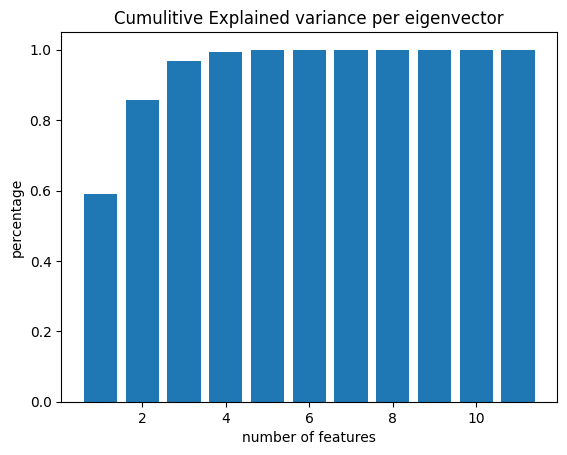

For explained variance: 0.95 number of components/dimentions: 3


In [126]:
best_components_list = get_principal_components(X_train_normalize)

### Comparison between forward selection and PCA

In [127]:
# calculate the test MSE for each reduced dataset
X_forward_reduced_train = X_train_normalize[:, best_features_list]

# get components based on train set:
X_pca_train = np.dot(X_train_normalize, best_components_list.T)
#x_pca_test = np.dot(X_test, train_components.T)

In [128]:
X_forward_reduced_train = pd.DataFrame(X_forward_reduced_train)
#X_forward_reduced_train = X_forward_reduced_train.rename(columns=dict(zip(X_forward_reduced_train.columns, train_data_features)))

In [129]:
X_forward_reduced_train

0
0     1.526445
1     1.444474
2     1.456866
3     1.491542
4     1.552139
...        ...
1126 -1.660398
1127 -1.660000
1128 -1.639820
1129 -1.631350
1130 -1.631862

[1131 rows x 1 columns]

#### Results
Using these new datasets, we will now print the train mse of each model:

In [130]:
# Create and fit the linear regression models
linear_reg_forward = LinearRegression().fit(X_forward_reduced_train, y_train)
linear_reg_pca = LinearRegression().fit(X_pca_train, y_train)

# Predict the target variable for the training set
y_pred_train_forward = linear_reg_forward.predict(X_forward_reduced_train)
y_pred_train_pca = linear_reg_pca.predict(X_pca_train)

# Predict the target variable for the test set
#y_pred_test_forward = linear_reg_forward.predict(X_forward_reduced_test)
#y_pred_test_pca = linear_reg_pca.predict(X_pca_test)

train_mse_forward = mean_squared_error(y_train, y_pred_train_forward)
#test_mse_forward = mean_squared_error(y_test, reg_forward_predict_test)
train_mse_pca = mean_squared_error(y_train, y_pred_train_pca)
#test_mse_pca = mean_squared_error(y_test, reg_pca_predict_test)

print(f'MSE train - PCA: {round(train_mse_pca,4)}')
#print(f'MSE test - PCA: {round(test_mse_pca,4)}')
print(f'MSE train - forward: {round(train_mse_forward,4)}')
#print(f'MSE test - forward: {round(test_mse_forward,4)}')

MSE train - PCA: 7.4578
MSE train - forward: 0.0


Choosing the best method to reduce dimensionality - 

In our case, forward selection got better results (smaller train MSE), using only 3 more features, having the original meaning of the features (compare to PCA that probably lost a lot of information that causes the tradeoff between information loss and dimensionality reduction to tends more to the side of information loss than the Forward selection). Therefor it seems better to use forward selection for this dataset, if we were to use Logistic Regression <br>

It is also important mentioning that we used a forward selection algorithm based on Logistic Regression Model for every one of our 4 Models that we will implement in the next section. The reason is because the of the high running time that takes for implement feature selection for every one of our models. We also want to mention that we are aware that if we would implement forward selection for every model separately (and not based only on the Logistic Regression) obviously we would get better results on the other 3 models (apart from the Logistic Regression model)

In [131]:
X_test_normalize.shape

(126, 11)

In [132]:
best_features_list

[0]

In [133]:
X_train_before_split = X_forward_reduced_train
#y_train_before_split = y_train.copy()
data_reduction = df.iloc[:, best_features_list]
X_Test = X_test_normalize[:, best_features_list]

## Manipulation of existing features

Turning the train and test data back to pandas and adding back the date column

In [134]:
X_train = pd.DataFrame(X_forward_reduced_train)
X_train['date'] = save_the_date_train
X_test = pd.DataFrame(X_test)
X_test['date'] = save_the_date_test

The following function converts numbers from scientific notation to regular notation:

* Adding the 'day', 'month' and 'year' categorical variables to the train data, then dropping the 'date' column

In [135]:
X_train['day'] = X_train['date'].dt.day
X_train['month'] = X_train['date'].dt.month
X_train['year'] = X_train['date'].dt.year
X_train = X_train.drop('date', axis=1)


In [136]:
y_train = pd.DataFrame(y_train)
train_new = pd.concat([X_train,y_train], axis=1)

* Adding the 'day', 'month' and 'year' categorical variables to the test data, then dropping the 'date' column

In [137]:
X_test['day'] = X_test['date'].dt.day
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year
X_test = X_test.drop('date', axis=1)

In [138]:
best_features_list1 = train_data_features[best_features_list].tolist()
best_features_list1

['open']

In [139]:
X_train = X_train.rename(columns=dict(zip(X_train.columns, best_features_list1)))

In [140]:
X_train['open'] = train_data['open']

In [46]:
X_train

high     close    volume    change      vwap  changeOverTime  day   
0     1.492306  1.509559 -1.411294 -0.321264  1.524196       -0.257610    9  \
1     1.461092  1.500024 -1.080906  1.306241  1.478088        0.863748    8   
2     1.469401  1.437592 -0.862550 -0.377473  1.457874       -0.299461    7   
3     1.444924  1.469149 -0.808571 -0.446457  1.459009       -0.344838    6   
4     1.553409  1.477549  0.249851 -1.619180  1.536915       -1.132167    5   
...        ...       ...       ...       ...       ...             ...  ...   
1126 -1.659349 -1.656825  0.503742  0.027487 -1.657916        0.182001   18   
1127 -1.654746 -1.668914  1.276421 -0.253558 -1.660642       -0.655326   17   
1128 -1.650648 -1.660173  1.011980 -0.510331 -1.653828       -1.390314   14   
1129 -1.631055 -1.629128  0.359062 -0.001895 -1.629297        0.089188   13   
1130 -1.634704 -1.639628  0.636695 -0.226731 -1.633159       -0.561040   12   

      month  year      open  
0         6  2023  181.5000  
1         6  2023  177.8950  
2         6  2023  178.4400  
3         6  2023  179.9650  
4         6  2023  182.6300  
...     ...   ...       ...  
1126     12  2018   41.3450  
1127     12  2018   41.3625  
1128     12  2018   42.2500  
1129     12  2018   42.6225  
1130     12  2018   42.6000  

[1131 rows x 10 columns]

## Label Definition

For our project we wanted to take a different approach that might bring insights to a larger audience. Instead of predicting the stock's price, which will be much less accurate, we want to predict the overall behavior of the stock by trying to estimate weather the price will go up, go down or stay within a window created by thresholds <br>

Due to the data we have on the stock , and mainly due to the information we don't have (earning or quarterly reports, media coverage about the company etc). Therefor, we would try to analyze the price with mathematic models and based on recent information we have on the stock.

In this section, we'll determine an initial window consisting of a lower and upper threshold values that will be calculated where the average will be today's price and the bound are 0.5 standard deviation to each direction by moving average of the past 30 days. This course of action helps us predict abnormal behaviors of the stock and will make it easier to classify

In the section of running and evaluating ML models, we'll also run a grid-search on a number of ways to create these thresholds and compare the results between them to get optimal results

In [141]:
# Calculate the moving average of the past 30 days
#train_new['moving_average'] = train_new['log_price'].rolling(window=30).mean()
train_new['moving_average'] = train_new['open'].rolling(window=30).mean()
# Calculate the standard deviation of the past 30 days
#train_new['standard_deviation'] = train_new['log_price'].rolling(window=30).std()
train_new['standard_deviation'] = train_new['open'].rolling(window=30).std()

# Calculate the lower and upper thresholds
train_new['lower_threshold'] = train_new['moving_average'] - (0.5 * train_new['standard_deviation'])
train_new['upper_threshold'] = train_new['moving_average'] + (0.5 * train_new['standard_deviation'])

# Get today's price and average
today_price = train_new['open'].iloc[-1]
today_average = train_new['moving_average'].iloc[-1]

print("Today's Price: $", today_price)
print("Today's Moving Average: $", today_average)
print("Lower Threshold: $", train_new['lower_threshold'].iloc[-1])
print("Upper Threshold: $", train_new['upper_threshold'].iloc[-1])
print("Window size = ",train_new['upper_threshold'].iloc[-1] - train_new['lower_threshold'].iloc[-1])


Today's Price: $ 42.6
Today's Moving Average: $ 38.97233333333334
Lower Threshold: $ 38.070366317768176
Upper Threshold: $ 39.8743003488985
Window size =  1.803934031130325


In [142]:

train_new['label'] = 0  # Initialize 'label' column to 0

train_new.loc[train_new['open'] < train_new['lower_threshold'], 'label'] = -1
train_new.loc[train_new['open'] > train_new['upper_threshold'], 'label'] = 1

# dror acc

In [143]:
def weighted_accuracy(y_true, y_pred):
    # Total number of samples
    L = len(y_true)
    # Number of samples where y_i = 0
    S = np.sum(np.array(y_true) == 0)

    # Weight for class 0
    weight_0 = (L - S) / L if S != 0 else 1

    # Initialize variables for correct classifications
    correct_classifications = 0

    # Iterate through true and predicted labels
    for yt, yp in zip(y_true, y_pred):
        # If the labels match
        if yt == yp:
            # If the label is 0, apply the custom weight
            if yt == 0:
                correct_classifications += weight_0
            # If the label is 1 or -1, apply a weight of 1
            else:
                correct_classifications += 1

    # Compute the final weighted accuracy
    accuracy = correct_classifications / L

    return accuracy

# dror func

In [144]:
def trend_sliding_window(data, window_size, horizon):
    """
    Create input/output pairs for trend prediction using a sliding window approach.
    Args:
        data (array-like): The time series data.
        window_size (int): The size of the sliding window.
        horizon (int): The prediction horizon indicating how many steps ahead to predict.

    Returns:
        tuple: A tuple containing the input sequences (X) and the corresponding output values (y).
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon ):
        input_window = data[i:i+window_size]
        X.append(input_window)      # Input Sequence
        output_window = data[ i + window_size  : i + window_size  + horizon]
        trend_value   = data[ i + window_size - 1  + horizon] - data[ i + window_size + 1]
        y.append(output_window)     # Output Sequence
    return np.array(X), np.array(y)


def sliding_window_th(data,labels ,window_size, horizon, th):
  X, y = [], []
  for i in range(len(data) - window_size - horizon ):
    input_window = data[i:i+window_size]
    trend_value = labels[ i + window_size + horizon - 1] -  labels[i+window_size - 1]
        
    if ( trend_value > th):
      y_trend =  1
    elif ( trend_value < -1*th):
      y_trend = -1
    else:
      y_trend = 0
    X.append(input_window)      # Input Sequence
    y.append(y_trend)     # Output Sequence
  return np.array(X), np.array(y)

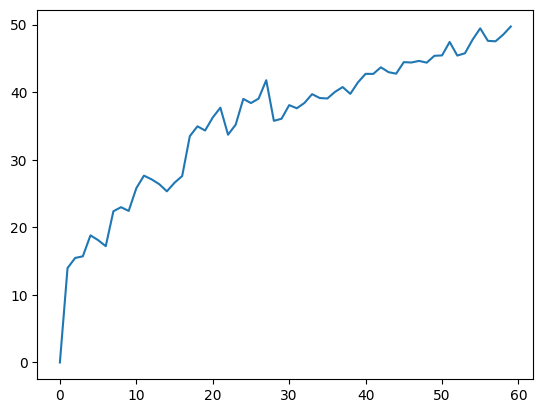

In [145]:
labels = X_train['open']
d = np.diff(labels)
np.max(d)
labels
def find_th_max(data_ts , h):
  max_jump = 0
  for i in range(len(data_ts) - h ):
    diff_h = np.abs(data_ts[i+h] - data_ts[i])
    if diff_h > max_jump:
      max_jump = diff_h
  return max_jump
# labels.values
lst_th = np.zeros(60)

for h in range(60):
  lst_th[h] = find_th_max (labels.values , h)

plt.plot(lst_th)

In [146]:
## full example: grid search over W , H , th
W_max  =  10
W_step =  3 # min W = 1
H_max  =  5
H_step =  2 # min H = 1
th_max =  5
th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = [] 
labels = X_train['open']
X_data = X_forward_reduced_train
max_acc = 0
values = []

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 5 * H_max
  W_step = W_max // 5
  th_max = int(find_th_max (labels.values, h)) + 1
  th_step = th_max // 5
  for th in range(0,th_max,th_step):
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_data, labels, w, h, th)
      
      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
      
      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence
      
      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      # Create and train the MLP classifier
      model = MLPClassifier(hidden_layer_sizes=(100, 100))  # Example MLP architecture

      # Now use X_Train_flat for training
      model.fit(X_Train_flat, y_Train)
      
      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)
      
      # Calculate and store the accuracy score
      accuracy = weighted_accuracy(y_val, y_pred)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy
      
      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      Y_arr_H_step.append(h)
      y_th_arr.append(th)

h: 1 th val: 0 w: 1
h: 1 th val: 0 w: 6
h: 1 th val: 0 w: 11
h: 1 th val: 0 w: 16
h: 1 th val: 0 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 2 w: 1
h: 1 th val: 2 w: 6
h: 1 th val: 2 w: 11
h: 1 th val: 2 w: 16
h: 1 th val: 2 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 4 w: 1
h: 1 th val: 4 w: 6
h: 1 th val: 4 w: 11
h: 1 th val: 4 w: 16
h: 1 th val: 4 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 6 w: 1
h: 1 th val: 6 w: 6
h: 1 th val: 6 w: 11
h: 1 th val: 6 w: 16
h: 1 th val: 6 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 8 w: 1
h: 1 th val: 8 w: 6
h: 1 th val: 8 w: 11
h: 1 th val: 8 w: 16
h: 1 th val: 8 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 1 th val: 10 w: 1
h: 1 th val: 10 w: 6
h: 1 th val: 10 w: 11
h: 1 th val: 10 w: 16
h: 1 th val: 10 w: 21
h: 1 th val: 12 w: 1
h: 1 th val: 12 w: 6
h: 1 th val: 12 w: 11
h: 1 th val: 12 w: 16
h: 1 th val: 12 w: 21
h: 3 th val: 0 w: 1
h: 3 th val: 0 w: 6
h: 3 th val: 0 w: 11
h: 3 th val: 0 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 0 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 3 w: 1
h: 3 th val: 3 w: 6
h: 3 th val: 3 w: 11
h: 3 th val: 3 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 3 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 6 w: 1
h: 3 th val: 6 w: 6
h: 3 th val: 6 w: 11
h: 3 th val: 6 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 6 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 9 w: 1
h: 3 th val: 9 w: 6
h: 3 th val: 9 w: 11
h: 3 th val: 9 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 9 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 12 w: 1
h: 3 th val: 12 w: 6
h: 3 th val: 12 w: 11
h: 3 th val: 12 w: 16


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 12 w: 21


c:\Users\niroe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


h: 3 th val: 15 w: 1
h: 3 th val: 15 w: 6
h: 3 th val: 15 w: 11
h: 3 th val: 15 w: 16
h: 3 th val: 15 w: 21


In [147]:
values

[[1, 1, 0, 0.5398230088495575],
 [1, 11, 0, 0.5446428571428571],
 [3, 1, 0, 0.5752212389380531],
 [3, 11, 0, 0.5803571428571429],
 [3, 16, 0, 0.6339285714285714]]

## Running & evaluating ML modules

Our ML modules will be Multi Layer Perceptron, Support Vector Machine, Random Forrest and Reaccuring Neural Network. 

In this part we'll run our modules, and if possible, try to understand the importance of features in our data to the label prediction.

We will be running them over the train dataset and try to improve them as much as possible, as well as evaluating them with time-series cross validation process as well as checking their performance using Accuracy score for every module.

We will also try to explain if our algorithm is overfitted, and if so, how can we solve (at least partially) this problem.

In this part, we'll chose our module for the test dataset prediction, based on which one of them preformed the best (highest Accuracy score).

Split the data to train and validation in order to test the success of our models:

In [53]:
X_train_before_split = pd.DataFrame(train_new)
X_Train = X_train_before_split.iloc[:int(len(train_new) * 0.9),:-1]
X_val = X_train_before_split.iloc[int(len(train_new) * 0.9):,:-1]
y_Train = X_train_before_split.iloc[:int(len(train_new) * 0.9),-1:]
y_val = X_train_before_split.iloc[int(len(train_new) * 0.9):,-1:]

In [54]:
X_Train = X_Train.rename(columns=dict(zip(X_Train.columns, best_features_list1)))

In [55]:
X_val = X_val.rename(columns=dict(zip(X_val.columns, best_features_list1)))

#### MLP

Multilayer Perceptron is a neural network where the mapping between inputs and output is non-linear.
A Multilayer Perceptron has input and output layers, and one or more hidden layers with many neurons stacked together. 
While a Perceptron in the neuron must have an activation function that imposes a threshold, like ReLU or sigmoid, neurons in a Multilayer Perceptron can use any arbitrary activation function.

![https://miro.medium.com/max/1100/1*MF1q2Q3fbpYlXX8fZUiwpA.webp](https://miro.medium.com/max/1100/1*MF1q2Q3fbpYlXX8fZUiwpA.webp)

In [56]:
#temp


warnings.filterwarnings('ignore')

parameters = {'hidden_layer_sizes': [50, 100, 150], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam']}
KF = TimeSeriesSplit(n_splits=5)
mlp_clf = MLPClassifier(random_state=0)
grid_search_ml = GridSearchCV(mlp_clf, parameters, cv=KF, scoring='accuracy')
grid_search_ml.fit(X_Train, y_Train)

# Obtain the best MLP classifier from the grid search
best_mlp_clf = grid_search_ml.best_estimator_

# Fit the best MLP classifier using the training data
best_mlp_clf.fit(X_Train, y_Train)

# Predict using the best MLP classifier
y_pred = best_mlp_clf.predict(X_val)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.78


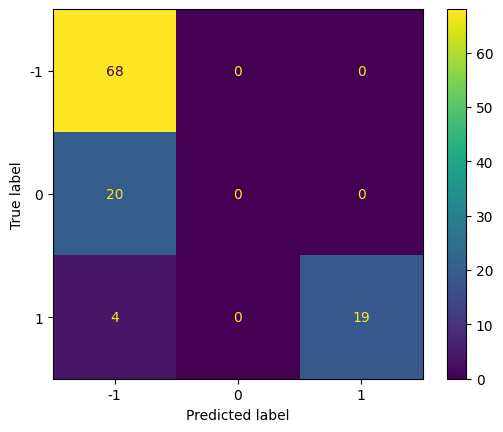

In [57]:
# creating a confusion matrix
cm = confusion_matrix(y_val, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
cm_display.plot()
plt.show()

In [58]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.74      1.00      0.85        68
           0       0.00      0.00      0.00        20
           1       1.00      0.83      0.90        23

    accuracy                           0.78       111
   macro avg       0.58      0.61      0.58       111
weighted avg       0.66      0.78      0.71       111



In [59]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

AttributeError: 'MLPClassifier' object has no attribute 'loss_curve_'

### SVM

SVM stands for Support Vector Machines. It is a supervised machine learning algorithm used for both classification and regression tasks.

In the context of classification, an SVM model is trained to find a hyperplane that separates different classes of data points. The goal is to maximize the margin between the hyperplane and the closest data points of each class. These closest data points are known as support vectors, which influence the position and orientation of the hyperplane.

SVMs can handle linearly separable data as well as non-linearly separable data by using a technique called the kernel trick. The kernel trick allows SVMs to implicitly map the input data into a higher-dimensional feature space, where it becomes linearly separable.

In the context of regression, SVMs can also be used to predict continuous values. Instead of finding a hyperplane, the algorithm aims to fit a hyperplane that captures the trend of the data. The hyperplane is then used to make predictions on new data points.

SVMs have several advantages, including their ability to handle high-dimensional data, their robustness against overfitting, and their effectiveness even with a small number of samples.

![https://miro.medium.com/v2/resize:fit:1400/1*qZFPN60NvwbFE_tRg2YPoQ.png](https://miro.medium.com/v2/resize:fit:1400/1*qZFPN60NvwbFE_tRg2YPoQ.png)

In [ ]:
warnings.filterwarnings('ignore')

parameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
KF = TimeSeriesSplit(n_splits=5)
svm_clf = SVC(random_state=0)
grid_search_svm = GridSearchCV(svm_clf, parameters, cv=KF, scoring='accuracy')
grid_search_svm.fit(X_Train, y_Train)

# Obtain the best SVM classifier from the grid search
best_svm_clf = grid_search_svm.best_estimator_

# Fit the best SVM classifier using the training data
best_svm_clf.fit(X_Train, y_Train)

# Predict using the best SVM classifier
y_pred = best_svm_clf.predict(X_val)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))

Accuracy: 0.51


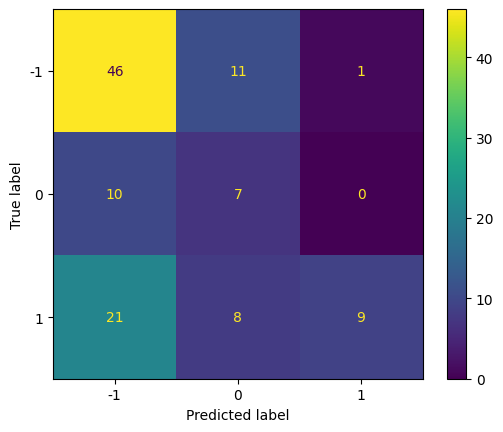

In [ ]:
cm = confusion_matrix(y_val, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
cm_display.plot()
plt.show()

In [148]:
## full example: grid search over W , H , th
W_max  =  10
W_step =  3 # min W = 1
H_max  =  5
H_step =  2 # min H = 1
th_max =  5
th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = [] 
labels = X_train['open']
X_data = X_forward_reduced_train
max_acc = 0
values = []

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 5 * H_max
  W_step = W_max // 5
  th_max = int(find_th_max (labels.values, h)) + 1
  th_step = th_max // 5
  for th in range(0,th_max,th_step):
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_data, labels, w, h, th)
      
      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
      
      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence
      
      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      # Create and train the MLP classifier
      model = model = SVC(kernel='linear')  # Example MLP architecture

      # Now use X_Train_flat for training
      model.fit(X_Train_flat, y_Train)
      
      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)
      
      # Calculate and store the accuracy score
      accuracy = weighted_accuracy(y_val, y_pred)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy
      
      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      Y_arr_H_step.append(h)
      y_th_arr.append(th)
      
values


h: 1 th val: 0 w: 1
h: 1 th val: 0 w: 6
h: 1 th val: 0 w: 11
h: 1 th val: 0 w: 16
h: 1 th val: 0 w: 21
h: 1 th val: 2 w: 1
h: 1 th val: 2 w: 6
h: 1 th val: 2 w: 11
h: 1 th val: 2 w: 16
h: 1 th val: 2 w: 21
h: 1 th val: 4 w: 1
h: 1 th val: 4 w: 6
h: 1 th val: 4 w: 11
h: 1 th val: 4 w: 16
h: 1 th val: 4 w: 21
h: 1 th val: 6 w: 1
h: 1 th val: 6 w: 6
h: 1 th val: 6 w: 11
h: 1 th val: 6 w: 16
h: 1 th val: 6 w: 21
h: 1 th val: 8 w: 1
h: 1 th val: 8 w: 6
h: 1 th val: 8 w: 11
h: 1 th val: 8 w: 16
h: 1 th val: 8 w: 21
h: 1 th val: 10 w: 1
h: 1 th val: 10 w: 6
h: 1 th val: 10 w: 11
h: 1 th val: 10 w: 16
h: 1 th val: 10 w: 21
h: 1 th val: 12 w: 1
h: 1 th val: 12 w: 6
h: 1 th val: 12 w: 11
h: 1 th val: 12 w: 16
h: 1 th val: 12 w: 21
h: 3 th val: 0 w: 1
h: 3 th val: 0 w: 6
h: 3 th val: 0 w: 11
h: 3 th val: 0 w: 16
h: 3 th val: 0 w: 21
h: 3 th val: 3 w: 1
h: 3 th val: 3 w: 6
h: 3 th val: 3 w: 11
h: 3 th val: 3 w: 16
h: 3 th val: 3 w: 21
h: 3 th val: 6 w: 1
h: 3 th val: 6 w: 6
h: 3 th val: 6 w: 11
h:

[[1, 1, 0, 0.5398230088495575],
 [1, 11, 0, 0.5446428571428571],
 [1, 21, 0, 0.5495495495495496],
 [3, 1, 0, 0.5752212389380531],
 [3, 11, 0, 0.5803571428571429],
 [3, 21, 0, 0.5855855855855856]]

### Random Forest

The basic idea behind Random Forest is to create an ensemble of decision trees, where each tree is trained on a different subset of the data and features. Random Forest introduces randomness in two ways: random sampling of the data and random feature selection.

During the training process, each tree in the Random Forest is trained on a random subset of the training data, known as bootstrap samples. Additionally, at each split in a tree, a random subset of features is considered for determining the best split.

When it comes to making predictions, each tree in the ensemble independently predicts the target variable, and the final prediction is determined by aggregating the individual predictions. For regression tasks, the predictions from each tree are averaged, while for classification tasks, the final prediction is often determined by majority voting.

Random Forest offers several advantages. It tends to have good predictive performance, can handle large and high-dimensional datasets, and is less prone to overfitting compared to individual decision trees. It can also provide measures of feature importance, allowing for variable selection and interpretation.

Overall, Random Forest is a versatile and powerful algorithm widely used in various domains due to its robustness and accuracy.

![https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

In [ ]:
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}
KF = TimeSeriesSplit(n_splits=5)
rf_clf = RandomForestClassifier(random_state=0)
grid_search_rf = GridSearchCV(rf_clf, parameters, cv=KF, scoring='accuracy')
grid_search_rf.fit(X_Train, y_Train)

# Obtain the best Random Forest classifier from the grid search
best_rf_clf = grid_search_rf.best_estimator_

# Fit the best Random Forest classifier using the training data
best_rf_clf.fit(X_Train, y_Train)

# Predict using the best Random Forest classifier
y_pred = best_rf_clf.predict(X_val)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))


Accuracy: 0.44


In [ ]:
cm = confusion_matrix(y_val, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
cm_display.plot()
plt.show()

#### Feature importance

In [ ]:
R_F_model = model_rf.fit(X_Train, y_Train)
importances = R_F_model.feature_importances_
desc_indices = np.argsort(importances)[::-1]
names = []
for i in desc_indices:
    names.append(train_data_reduction.columns[i])

plt.figure(figsize=(10,7))
plt.title("Feature Importance - Random Forest")
plt.bar(range(X_Train.shape[1]), importances[desc_indices], color='lightblue', align='center')
plt.xticks(range(X_Train.shape[1]), names, rotation='vertical')
plt.xlim([-1, X_Train.shape[1]])
plt.show()

# Print the feature ranking
print("Feature Ranking:")
for i, feature in enumerate(train_data_reduction.columns[desc_indices]):
    print(("{}. {} ({:.2f}%)").format(i+1, feature, importances[desc_indices][i]*100))

Feature importance conclusions - Random Forest

We can see that we have two main features that contibute the most to our Random Forest Model. The first one is PageValues and the second one is ExitRates. Our intuition to why these features most important is because PageValues represents the average value for a page that a user visited right before he got to his goal page or made an ecommerce transaction. Our intuition for the second one is that it makes sense that someone has left the website and it depends on the page he was on (a page that he made a purchase or just left the site - tells us a lot about about purchases)

#### Visualization of the Random Forest Classifier Model -

In [ ]:
from sklearn import tree

# Arrange Data into Features Matrix and Target Vector
X = X_Train
y = y_Train

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

# Random Forests in `scikit-learn` (with N = 100)
rf = RandomForestClassifier(**best_params_rf).fit(X_train, Y_train)
                          
fn=data_reduction.columns
cn='Purchase'
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [149]:
## full example: grid search over W , H , th
W_max  =  10
W_step =  3 # min W = 1
H_max  =  5
H_step =  2 # min H = 1
th_max =  5
th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = [] 
labels = X_train['open']
X_data = X_forward_reduced_train
max_acc = 0
values = []

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 5 * H_max
  W_step = W_max // 5
  th_max = int(find_th_max (labels.values, h)) + 1
  th_step = th_max // 5
  for th in range(0,th_max,th_step):
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_data, labels, w, h, th)
      
      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
      
      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence
      
      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      # Create and train the MLP classifier
      model = RandomForestClassifier(n_estimators=100, random_state=0)

      # Now use X_Train_flat for training
      model.fit(X_Train_flat, y_Train)
      
      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)
      
      # Calculate and store the accuracy score
      accuracy = weighted_accuracy(y_val, y_pred)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy
      
      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      Y_arr_H_step.append(h)
      y_th_arr.append(th)
      
values


h: 1 th val: 0 w: 1
h: 1 th val: 0 w: 6
h: 1 th val: 0 w: 11
h: 1 th val: 0 w: 16
h: 1 th val: 0 w: 21
h: 1 th val: 2 w: 1
h: 1 th val: 2 w: 6
h: 1 th val: 2 w: 11
h: 1 th val: 2 w: 16
h: 1 th val: 2 w: 21
h: 1 th val: 4 w: 1
h: 1 th val: 4 w: 6
h: 1 th val: 4 w: 11
h: 1 th val: 4 w: 16
h: 1 th val: 4 w: 21
h: 1 th val: 6 w: 1
h: 1 th val: 6 w: 6
h: 1 th val: 6 w: 11
h: 1 th val: 6 w: 16
h: 1 th val: 6 w: 21
h: 1 th val: 8 w: 1
h: 1 th val: 8 w: 6
h: 1 th val: 8 w: 11
h: 1 th val: 8 w: 16
h: 1 th val: 8 w: 21
h: 1 th val: 10 w: 1
h: 1 th val: 10 w: 6
h: 1 th val: 10 w: 11
h: 1 th val: 10 w: 16
h: 1 th val: 10 w: 21
h: 1 th val: 12 w: 1
h: 1 th val: 12 w: 6
h: 1 th val: 12 w: 11
h: 1 th val: 12 w: 16
h: 1 th val: 12 w: 21
h: 3 th val: 0 w: 1
h: 3 th val: 0 w: 6
h: 3 th val: 0 w: 11
h: 3 th val: 0 w: 16
h: 3 th val: 0 w: 21
h: 3 th val: 3 w: 1
h: 3 th val: 3 w: 6
h: 3 th val: 3 w: 11
h: 3 th val: 3 w: 16
h: 3 th val: 3 w: 21
h: 3 th val: 6 w: 1
h: 3 th val: 6 w: 6
h: 3 th val: 6 w: 11
h:

[[1, 1, 0, 0.4424778761061947],
 [1, 6, 0, 0.45132743362831856],
 [1, 11, 0, 0.48214285714285715],
 [1, 16, 0, 0.5],
 [3, 6, 0, 0.5132743362831859],
 [3, 11, 0, 0.5267857142857143]]

By the Tree plot we can see that Random forest works on several decision tree. Plotting them gives a hunch basically how a model predicts the value of a target variable by learning simple decision rules inferred from the data features. Every decision at a node is made by classification using single feature from our train data.

### RNN

Recurrent Neural Networks (RNNs) are a type of artificial neural network designed to process sequential data, such as time series or natural language. RNNs have a "recurrent" structure that allows them to maintain and update an internal state as they process each element of the input sequence.

![https://cdn.ttgtmedia.com/rms/onlineimages/enterpriseai-recurrent_neural_network-f_mobile.png](https://cdn.ttgtmedia.com/rms/onlineimages/enterpriseai-recurrent_neural_network-f_mobile.png)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(X_Train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary


<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x0000023A1E037190>>

In [ ]:
model.compile(optimizer='adam',
			loss='mean_squared_error')
history = model.fit(X_Train,
					y_train,
					epochs=10)


Epoch 1/10
32/32 [==============================] - 4s 13ms/step - loss: 3.2729
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 1.0112
Epoch 3/10
32/32 [==============================] - 0s 14ms/step - loss: 0.8217
Epoch 4/10
32/32 [==============================] - 0s 15ms/step - loss: 0.7617
Epoch 5/10
32/32 [==============================] - 1s 16ms/step - loss: 0.6712
Epoch 6/10
32/32 [==============================] - 0s 14ms/step - loss: 0.6765
Epoch 7/10
32/32 [==============================] - 0s 13ms/step - loss: 0.7246
Epoch 8/10
32/32 [==============================] - 0s 14ms/step - loss: 0.7903
Epoch 9/10
32/32 [==============================] - 0s 13ms/step - loss: 0.6386
Epoch 10/10
32/32 [==============================] - 0s 13ms/step - loss: 0.7027


In [ ]:
# Predict using the RNN model
y_pred_prob = model.predict(X_val).flatten()
y_pred = np.round(y_pred_prob).astype(int)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))


4/4 [==============================] - 1s 2ms/step
Accuracy: 0.00


In [ ]:
# Reshape the input data to fit the RNN input requirements
X_Train = np.expand_dims(X_Train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Trim the target data to match the number of samples in X_Train
y_train = y_train[:X_Train.shape[0]]
y_val = y_val[:X_val.shape[0]]

# Create the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(units=50, input_shape=(X_Train.shape[1], X_Train.shape[2])))
rnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the RNN model
rnn_model.fit(X_Train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict using the RNN model
y_pred_prob = rnn_model.predict(X_val).flatten()
y_pred = np.round(y_pred_prob).astype(int)

print('Accuracy: {:.2f}'.format(accuracy_score(y_val, y_pred)))


Epoch 1/10
32/32 [==============================] - 3s 7ms/step - loss: -7.4454 - accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 7ms/step - loss: -26.9836 - accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 8ms/step - loss: -43.0836 - accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: -52.4990 - accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 7ms/step - loss: -60.2758 - accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 7ms/step - loss: -67.5496 - accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 8ms/step - loss: -74.5480 - accuracy: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 7ms/step - loss: -81.3777 - accuracy: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 8ms/step - loss: -88.0924 - accuracy: 0.0000e+00
Epoch 10/10
4/4 [==============================] - 3s 3ms/step
Ac

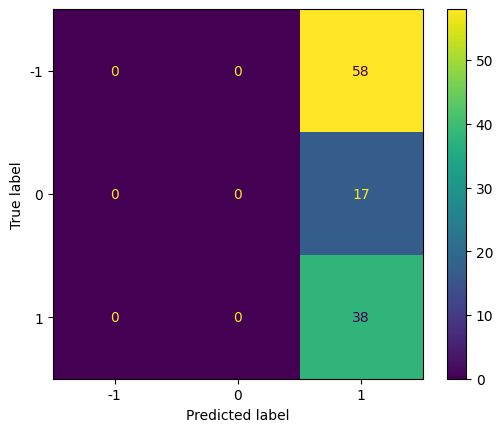

In [ ]:
cm = confusion_matrix(y_val, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
cm_display.plot()
plt.show()

In [151]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## full example: grid search over W , H , th
W_max  =  10
W_step =  3 # min W = 1
H_max  =  5
H_step =  2 # min H = 1
th_max =  5
th_step = 0.5
y_th_arr = []
X_arr_W    = []
Y_arr_H    = []
Y_arr_H_step    = [] 
labels = X_train['open']
X_data = X_forward_reduced_train
max_acc = 0
values = []

### Optimize over Validation dataset: Creating grid arrays
for h in range(1,H_max,H_step):
  W_max = 5 * H_max
  W_step = W_max // 5
  th_max = int(find_th_max (labels.values, h)) + 1
  th_step = th_max // 5
  for th in range(0,th_max,th_step):
    for w in range(1, W_max, W_step):
      print ('h:' , h,'th val:' , th, 'w:', w)
      X, y = sliding_window_th(X_data, labels, w, h, th)
      
      # Split the data into training and validation sets
      X_Train, X_val, y_Train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)
      
      num_samples, window_size, num_features = X_Train.shape
      X_Train_flat = X_Train.reshape(num_samples, -1)  # Flatten each window sequence
      
      num_samples, window_size, num_features = X_val.shape
      X_val_flat = X_val.reshape(num_samples, -1)  # Flatten each window sequence
      
      # Create and train the RNN model
      model = Sequential([
                LSTM(100, input_shape=(window_size, num_features)),  # Example LSTM layer with 100 units
                Dense(1, activation='sigmoid')  # Output layer
            ])
            
      model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
            # Train the model
      model.fit(X_Train, y_Train, epochs=10, batch_size=32)

      # Now use X_Train_flat for training
      model.fit(X_Train, y_Train, epochs=10, batch_size=32)
      
      # Make predictions on the validation set
      y_pred = model.predict(X_val_flat)
      
      # Calculate and store the accuracy score
      accuracy = weighted_accuracy(y_val, y_pred)
      if accuracy > max_acc:
        values.append([h, w, th, accuracy])
        max_acc = accuracy
      
      # Store the results for each combination of W, H, th
      X_arr_W.append(w)
      Y_arr_H.append(h)
      Y_arr_H_step.append(h)
      y_th_arr.append(th)
      
values


h: 1 th val: 0 w: 1
Epoch 1/10
32/32 [==============================] - 6s 4ms/step - loss: 0.6481 - accuracy: 0.0453
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.5412 - accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.4016 - accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.2372 - accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0793 - accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: -0.0598 - accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: -0.1682 - accuracy: 0.0000e+00
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: -0.2597 - accuracy: 0.0000e+00
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: -0.3349 - accuracy: 0.0000e+00
Epoch 10/10
32/32 [==============================] - 0s 4ms/st

[]

In [152]:
values

[]

### Choosing the best model

As seen in the last section, we got the best accuracy score for ???.Therefor we'll use this model to make our predictions later on.

Confusion Matrix on the ??? Model with the validation data in order to evaluate our model:
צריך להחליף לפי המודל שלנו

In [ ]:
# Using seaborn
RF_train_predict = grid_search_rf.predict(X_val)
C_m = confusion_matrix(y_val, RF_train_predict)
tn, fp, fn, tp = C_m.ravel()
C_m = np.array([[tp,fp],[fn,tn]])

print("Validation confusion Matrix:")
sns.heatmap(C_m, annot=True, fmt='g', cmap='Greens', xticklabels = [0,1], yticklabels = [0,1])
plt.show()

print("Validation Accuracy:", (tp+tn) / C_m.sum())

explenation for validation confusion matrix:
???

#### Differences between train and validation

In this section we'd like to find out if our best ML model by accuracy score suffers from overfitting.
Overfitting is a common problem in machine learning where a model learns the training data too well, resulting in poor performance on unseen data. It occurs when a model becomes overly complex and captures noise or random fluctuations in the training data as genuine patterns. This leads to the model fitting the training data perfectly but failing to generalize to new examples.
To check if this is the case, we'll plot a ROC curve for our train data. If the AUC that we get will be very close to 1, we can assume our model suffers from overfitting, otherwise we're all good.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

metrics.plot_roc_curve(clf_lr, X_Train, y_Train)
plt.show()

Conclusions from the differences between the Train and Validation (Overfitting):<br>
Based on the chosen model, we have got Train And test AUC of ???. Therefore, this model is ??? overfitted.
להוסיף הסבר כשיהיו תוצאות

## Making a prediction

In this part we'll make our predictions on the test dataset we've created using the module who preformed the best out of all modules we ran in earlier stages of the project - ???.

After the testing, we will discuss our results (and how good they are) and insights we got from our project with regards to the dataset in hand.

## Recap & Conclusions